# Prototyping

## Necessary Packages and initialization

In [376]:
#Coinbase API
import cbpro
#Packages/functions to list files in folders
from os import listdir
from os.path import isfile, join
#Clear function for jupyter
from IPython.display import clear_output
#Package for fast c-compiled functions
from numba import njit
#Package for paralell processing
from concurrent.futures import ThreadPoolExecutor

#Regular Ol' libraries
import pandas as pd
import pickle as pkl
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import time

#My Libraries
import coinbaseFunctions as cf
import utilityFunctions as uf
import financialFunctions as ff

#Makes it so a module/library is changed, it updates automatically on the code
%load_ext autoreload
%autoreload 2

#Clears some stuff
clear_output()

#Defines and initialized Client instant to access Coinbase
with open('/home/andrerg01/AutoTraders/fredinhouTradingBot_Pvt/coinbase_credentials.pkl', 'rb') as f:
    credentials = pkl.load(f)
Client = cbpro.AuthenticatedClient(
    credentials['APIKey'],
    credentials['SecretKey'],
    credentials['passPhrase'],
    api_url = credentials['APIurl']
    )

#Assets to be considered for purchasing
assets = ['AAVE-USD', 'ADA-USD', 'ALGO-USD', 'ATOM-USD', 'BAL-USD', 'BAND-USD', 'BCH-USD', 'BNT-USD', 'BTC-USD', 'CGLD-USD', 'COMP-USD',\
                 'DASH-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'FIL-USD', 'GRT-USD', 'KNC-USD', 'LINK-USD', 'LRC-USD', 'LTC-USD', 'MATIC-USD',\
                 'MKR-USD', 'NMR-USD', 'NU-USD', 'OMG-USD', 'OXT-USD', 'REN-USD', 'REP-USD', 'SKL-USD', 'SNX-USD', 'SUSHI-USD', 'UMA-USD',
                 'UNI-USD','WBTC-USD', 'XLM-USD', 'XTZ-USD', 'YFI-USD', 'ZEC-USD', 'ZRX-USD']



## Data Retrival

In [14]:
#Starting time for collected data.
start = datetime.datetime(2016,3,27)
#Ending time for collected data.
end = datetime.datetime.now()
#How many seconds in between chuncks of data, allowed values are: [60, 300, 900, 3600, 21600, 86400]
granularity = 24*60*60 #that's 86400 = 1 day
#Getting data from start to end for 'BTC-USD' with given granularity
data = cf.getData(Client, 'BTC-USD', start, end, granularity = granularity, verbose = False)
#Showing data
data

Retrieving data for BTC-USD

Retrieving data for BTC-USD
Failure in retreiving data for BTC-USD. Waiting 1 second and trying again. 1/10
{'message': 'Public rate limit exceeded'}


,low,high,open,close,volume
date,,,,,
2016-03-27,416.35,426.50,416.96,425.30,4658.098031
2016-03-28,419.63,425.36,425.29,423.00,5717.860071
2016-03-29,407.75,424.62,422.92,416.39,7361.855275
2016-03-30,407.56,416.41,416.40,412.79,5831.493604
2016-03-31,412.74,417.60,412.97,416.03,5235.542784
...,...,...,...,...,...
2021-04-13,59799.01,63774.39,59836.88,63588.22,17897.766031
2021-04-14,61277.91,64899.00,63588.22,62971.80,22570.841134
2021-04-15,62036.73,63831.82,62971.80,63229.04,11209.450528


## Calculating Indicators

In [48]:
#Return
data['return'] = ff.returns(data['close'].values)
#Moving average
data['MA-7'] = ff.MA(data['close'].values, window = 7)
#Exponential moving average
data['EMA-12'] = ff.EMA(data['close'].values, window = 7)
#MACD = EMA convergence/divergence
data['MACD-12-26'] = ff.MACD(data['close'].values, window1 = 12, window2 = 26)
#MACD's EMA
data['DEA-12-26-9'] = ff.DEA(data['close'].values, window1 = 12, window2 = 26, window3 = 9)
#Difference between MACD and DEA
data['OSC-12-26-9'] = ff.OSC(data['close'].values, window1 = 12, window2 = 26, window3 = 9)
#Relative Strength Index
data['RSI-14'] = ff.RSI(data['close'].values, window = 14)
#On-Balance Volume
data['OBV'] = ff.OBV(data['close'].values, data['volume'].values)
#Lowest value of last n periods
data['7-Day-Low'] = ff.nPeriodLow(data['close'].values, window = 7)
#Highest value of last n periods
data['7-Day-High'] = ff.nPeriodHigh(data['close'].values, window = 7)
data

,low,high,open,close,volume,return,MA-7,EMA-12,MACD-12-26,DEA-12-26-9,OSC-12-26-9,RSI-14,OBV,7-Day-Low,7-Day-High
date,,,,,,,,,,,,,,,
2016-03-27,416.35,426.50,416.96,425.30,4658.098031,NaN,NaN,425.300000,0.000000,0.000000,0.000000,NaN,4.658098e+03,NaN,NaN
2016-03-27,416.35,426.50,416.96,425.30,4658.098031,0.000000,NaN,425.300000,0.000000,0.000000,0.000000,NaN,4.658098e+03,NaN,NaN
2016-03-28,419.63,425.36,425.29,423.00,5717.860071,-0.005408,NaN,424.725000,-0.183476,-0.036695,-0.146781,0.000000,-1.059762e+03,NaN,NaN
2016-03-28,419.63,425.36,425.29,423.00,5717.860071,0.000000,NaN,424.293750,-0.325134,-0.094383,-0.230751,0.000000,-1.059762e+03,NaN,NaN
2016-03-29,407.75,424.62,422.92,416.39,7361.855275,-0.015626,NaN,422.317813,-0.959708,-0.267448,-0.692260,0.000000,-8.421617e+03,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-11,59177.06,60658.89,59778.59,59985.26,7278.965167,0.003457,58266.358571,59009.166239,608.801648,456.068004,152.733645,71.205934,1.775038e+06,55955.75,59778.60
2021-04-11,59177.06,60658.89,59778.59,59985.26,7278.965167,0.000000,58842.002857,59253.189679,672.716986,499.397800,173.319185,71.205934,1.775038e+06,58083.10,59985.26
2021-04-12,59369.00,61199.00,59983.66,59839.82,11467.727530,-0.002425,59113.740000,59399.847260,703.524763,540.223193,163.301570,67.921423,1.763571e+06,58083.10,59985.26


## Simple Strategies

In [5]:
#Gatting data
start = datetime.datetime(2016,3,27)
end = datetime.datetime.now()
granularity = 24*60*60
dataOriginal = cf.getData(Client, 'BTC-USD', start, end, granularity = granularity)
clear_output()

CPU times: user 524 µs, sys: 48 µs, total: 572 µs
Wall time: 577 µs
Mean Return: 0.10648342380801308
Mean Daily Return for active periods: 0.020180542553843047
Mean Daily Return Overall: 0.00641939740371656
Mean number of activations per day: 0.014084507042253521
Strategy Score: 1.236356135584363


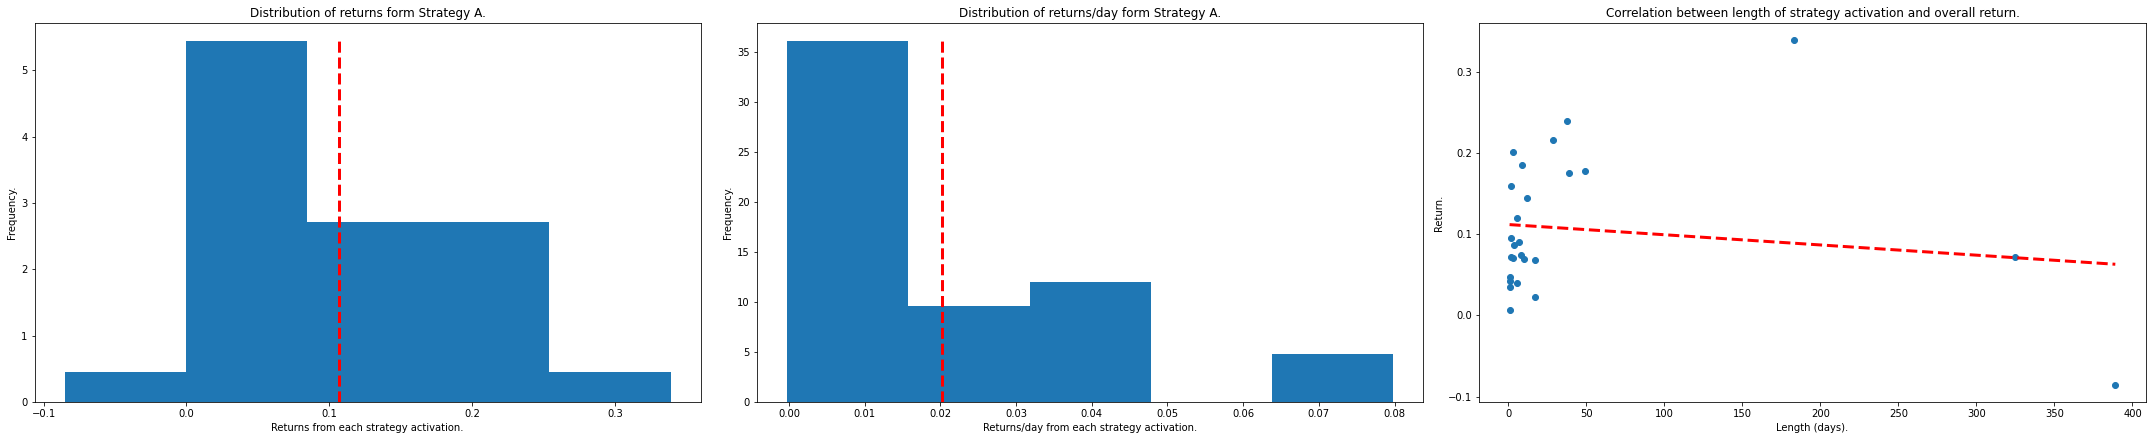

In [21]:
data = dataOriginal.copy()
#nDayLow = 7
#nDayHigh = 7
#MAperiod = 100
MAperiod = 8
nDayLow = 3
nDayHigh = 183
nLimits = np.array([2,len(data)])
%time arrReturn, arrLength, arrPurchased, score, N, parameters = ff.backtestStrategyA(dataOriginal['close'].values, MAperiod, nDayLow, nDayHigh, nLimits)
print("Mean Return: " + str(np.mean(arrReturn)))
print("Mean Daily Return for active periods: " + str(np.mean(arrReturn/arrLength)))
print("Mean Daily Return Overall: " + str((np.prod(1+arrReturn) - 1)/len(arrPurchased)))
print("Mean number of activations per day: " + str(len(arrReturn)/len(arrPurchased)))
print("Strategy Score: " + str(score))

fig, ax = plt.subplots(1, 3, figsize = [30, 10/1.61])
n1, bins1, patches1 = ax[0].hist(arrReturn, bins = int(np.sqrt(len(arrReturn))), density = True)
ax[0].set_title("Distribution of returns form Strategy A.")
ax[0].set_xlabel("Returns from each strategy activation.")
ax[0].set_ylabel("Frequency.")
ax[0].plot([np.mean(arrReturn), np.mean(arrReturn)],[0, np.max(n1)], 'r--', linewidth = 3.0)

n2, bins2, patches2 = ax[1].hist(arrReturn/arrLength, bins = int(np.sqrt(len(arrReturn))), density = True)
ax[1].set_title("Distribution of returns/day form Strategy A.")
ax[1].set_xlabel("Returns/day from each strategy activation.")
ax[1].set_ylabel("Frequency.")
ax[1].plot([np.mean(arrReturn/arrLength), np.mean(arrReturn/arrLength)],[0, np.max(n2)], 'r--', linewidth = 3.0)

ax[2].scatter(arrLength, arrReturn)
ax[2].set_title("Correlation between length of strategy activation and overall return.")
ax[2].set_xlabel("Length (days).")
ax[2].set_ylabel("Return.")
m, b = np.polyfit(arrLength, arrReturn, 1)
x = np.linspace(min(arrLength), max(arrLength))
y = m*x + b
ax[2].plot(x, y, 'r--', linewidth = 3.0)

fig.tight_layout()


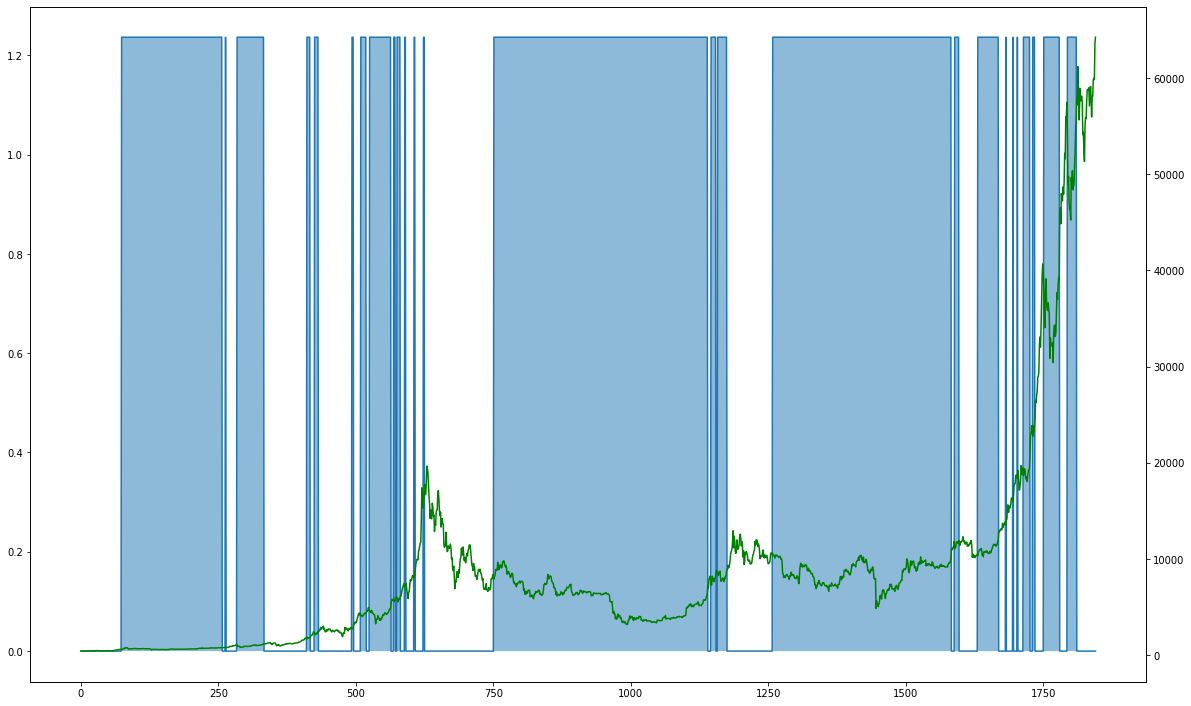

In [22]:
fig, ax = plt.subplots(figsize = [20, 20/1.61])
ax.plot(arrPurchased*score)
ax.fill_between(np.arange(len(arrPurchased)),arrPurchased*score, alpha = .5)
ax2 = ax.twinx()
ax2.plot(data['close'].values, color = 'green')

In [8]:
#Optimizing Strategy A Parameters
nDayLowVals = np.arange(2,14)
nDayHighVals = np.arange(2,14)
MAperiodVals = np.arange(28, int(0.1*len(dataOriginal)))
#Minimum of one activation every 90 days
minN = int(len(dataOriginal)/90)
#Maximum of one activation per 4 days
maxN = int(len(dataOriginal)/4)
argCombinations = []
for p1 in nDayLowVals:
    for p2 in nDayHighVals:
        for p3 in MAperiodVals:
            argCombinations += [(dataOriginal['close'].values, p1, p2, p3, np.array([minN, maxN], dtype = np.float64))]

In [10]:
%%time
with ThreadPoolExecutor(8) as ex:   
    results = ex.map(lambda p: ff.backtestStrategyA(*p), argCombinations)
results = np.array([result for result in results])


CPU times: user 10.7 s, sys: 233 ms, total: 11 s
Wall time: 4.57 s


<timed exec>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
results_df = pd.DataFrame(results, columns = ['returns', 'lengths', 'purchasedBool', 'score', 'N', 'parameters'])
results_df = results_df.sort_values(by = 'score')
best = results_df.tail(10).sort_values(by = 'N').iloc[-1]
if best['score'] < 0:
    best['score'] = 0
best.to_dict()


{'returns': array([ 0.33900184,  0.00621006,  0.17864945,  0.12004529,  0.09076869,
         0.20133709,  0.06906127,  0.17594924,  0.07062925,  0.03962418,
         0.07148022,  0.09517181,  0.15958852, -0.08516745,  0.1857805 ,
         0.02283306,  0.07178153,  0.07509482,  0.23907298,  0.03484276,
         0.04758284,  0.04286254,  0.14479234,  0.08690551,  0.21682446,
         0.06784624]),
 'lengths': array([183.,   1.,  49.,   6.,   7.,   3.,  10.,  39.,   3.,   6.,   2.,
          2.,   2., 389.,   9.,  17., 325.,   8.,  38.,   1.,   1.,   1.,
         12.,   4.,  29.,  17.]),
 'purchasedBool': array([False, False, False, ..., False, False, False]),
 'score': 1.236356135584363,
 'N': 26,
 'parameters': array([  8,   3, 180])}

CPU times: user 849 ms, sys: 0 ns, total: 849 ms
Wall time: 848 ms
Mean Return: 0.301369387483456
Mean Daily Return for active periods: 0.008662814150694934
Mean Daily Return Overall: 0.31589205067581344
Mean number of activations per day: 0.014626218851570965
Strategy Score: 0.9275509154595535


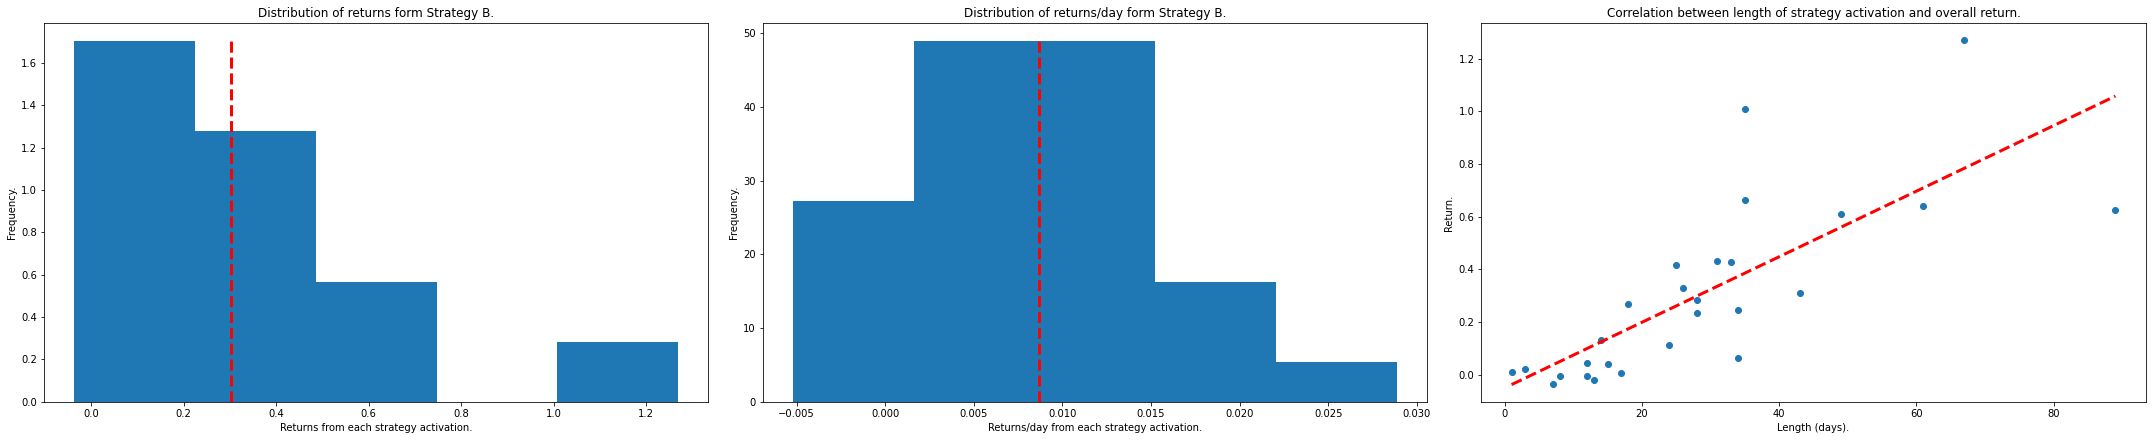

In [18]:
data = dataOriginal.copy()
# RSIperiod = 14
# RSILow = 33.33
# RSIHigh = 66.66
RSIperiod = 18
RSILow = 48
RSIHigh = 67

%time arrReturn, arrLength, arrPurchased, score, N, parameters = ff.backtestStrategyB(dataOriginal['close'].values, RSIperiod, RSILow, RSIHigh, nLimits)
print("Mean Return: " + str(np.mean(arrReturn)))
print("Mean Daily Return for active periods: " + str(np.mean(arrReturn/arrLength)))
print("Mean Daily Return Overall: " + str((np.prod(1+arrReturn) - 1)/len(arrPurchased)))
print("Mean number of activations per day: " + str(len(arrReturn)/len(arrPurchased)))
print("Strategy Score: " + str(score))

fig, ax = plt.subplots(1, 3, figsize = [30, 10/1.61])
n1, bins1, patches1 = ax[0].hist(arrReturn, bins = int(np.sqrt(len(arrReturn))), density = True)
ax[0].set_title("Distribution of returns form Strategy B.")
ax[0].set_xlabel("Returns from each strategy activation.")
ax[0].set_ylabel("Frequency.")
ax[0].plot([np.mean(arrReturn), np.mean(arrReturn)],[0, np.max(n1)], 'r--', linewidth = 3.0)

n2, bins2, patches2 = ax[1].hist(arrReturn/arrLength, bins = int(np.sqrt(len(arrReturn))), density = True)
ax[1].set_title("Distribution of returns/day form Strategy B.")
ax[1].set_xlabel("Returns/day from each strategy activation.")
ax[1].set_ylabel("Frequency.")
ax[1].plot([np.mean(arrReturn/arrLength), np.mean(arrReturn/arrLength)],[0, np.max(n2)], 'r--', linewidth = 3.0)

ax[2].scatter(arrLength, arrReturn)
ax[2].set_title("Correlation between length of strategy activation and overall return.")
ax[2].set_xlabel("Length (days).")
ax[2].set_ylabel("Return.")
m, b = np.polyfit(arrLength, arrReturn, 1)
x = np.linspace(min(arrLength), max(arrLength))
y = m*x + b
ax[2].plot(x, y, 'r--', linewidth = 3.0)

fig.tight_layout()


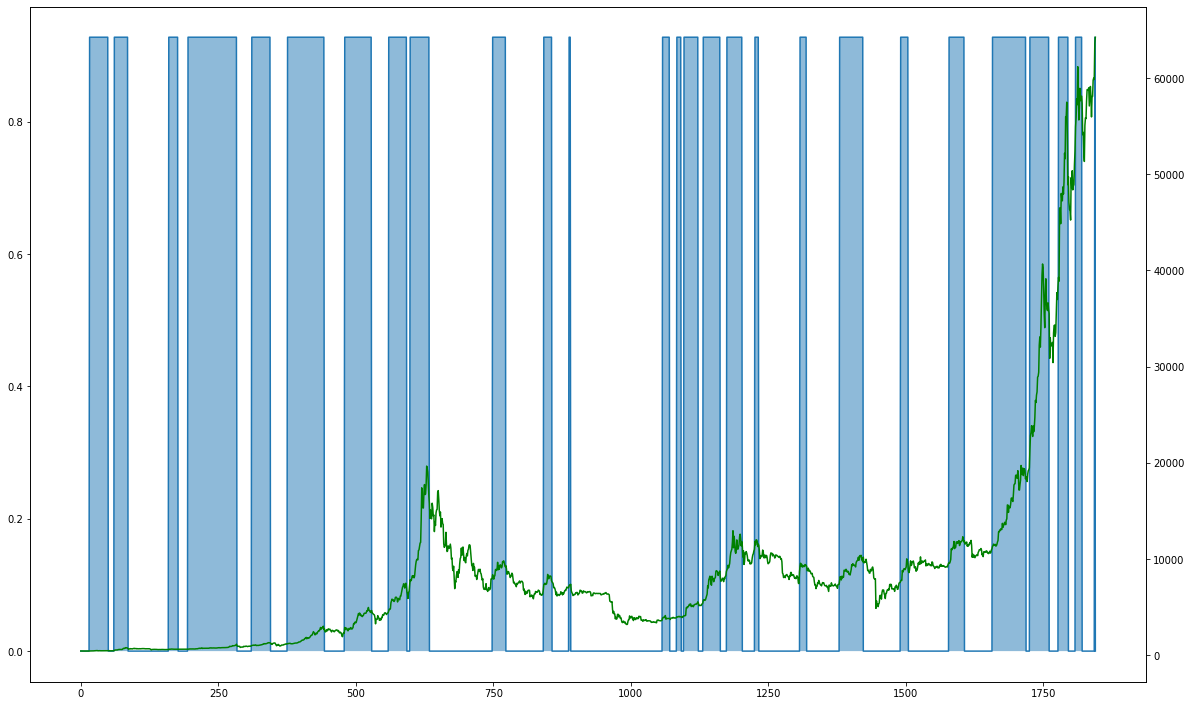

In [19]:
fig, ax = plt.subplots(figsize = [20, 20/1.61])
ax.plot(arrPurchased*score)
ax.fill_between(np.arange(len(arrPurchased)),arrPurchased*score, alpha = .5)
ax2 = ax.twinx()
ax2.plot(data['close'].values, color = 'green')


In [23]:
#Optimizing Strategy B Parameters
RSIperiodVals = np.arange(5,int(0.1*len(dataOriginal)))
RSILowVals = np.arange(20,49)
RSIHighVals = np.arange(51, 80)
#Minimum of one activation every 90 days
minN = int(len(dataOriginal)/90)
#Maximum of one activation per 4 days
maxN = int(len(dataOriginal)/4)
argCombinations = []
for p1 in RSIperiodVals:
    for p2 in RSILowVals:
        for p3 in RSIHighVals:
            argCombinations += [(dataOriginal['close'].values, p1, p2, p3, np.array([minN, maxN], dtype = np.float64))]

In [24]:
%%time
with ThreadPoolExecutor(8) as ex:   
    results = ex.map(lambda p: ff.backtestStrategyB(*p), argCombinations)
results = np.array([result for result in results])

CPU times: user 22.7 s, sys: 1.62 s, total: 24.3 s
Wall time: 13.2 s


<timed exec>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [25]:
results_df = pd.DataFrame(results, columns = ['returns', 'lengths', 'purchasedBool', 'score', 'N', 'parameters'])
results_df = results_df.sort_values(by = 'score')
best = results_df.tail(10).sort_values(by = 'N').iloc[-1]
if best['score'] < 0:
    best['score'] = 0
best.to_dict()

{'returns': array([ 0.06489014,  0.41672502,  0.00780483,  0.5682427 ,  0.24639637,
         1.2370579 ,  0.51384384,  0.42883334,  0.90876707,  0.07842494,
         0.02992614,  0.02349021, -0.02070597,  1.01097759,  0.26686128,
        -0.08160843, -0.00658115,  0.18403828,  0.19144607,  0.22267311,
         0.61542015,  0.66215692,  0.26670764,  0.0263484 ]),
 'lengths': array([36., 25., 17., 86., 34., 65., 50., 33., 31., 25., 16.,  3., 13.,
        75., 27.,  8., 12., 48., 27., 32., 62., 35., 18., 11.]),
 'purchasedBool': array([False, False, False, ..., False,  True,  True]),
 'score': 0.941226872860375,
 'N': 24,
 'parameters': array([16, 44, 70])}

CPU times: user 1.01 s, sys: 2.15 ms, total: 1.01 s
Wall time: 1.01 s
Mean Return: 0.37174133817323807
Mean Daily Return for active periods: 0.008712008389619432
Mean Daily Return Overall: 0.41645529914670654
Mean number of activations per day: 0.012459371614301192
Strategy Score: 1.1127860230293813


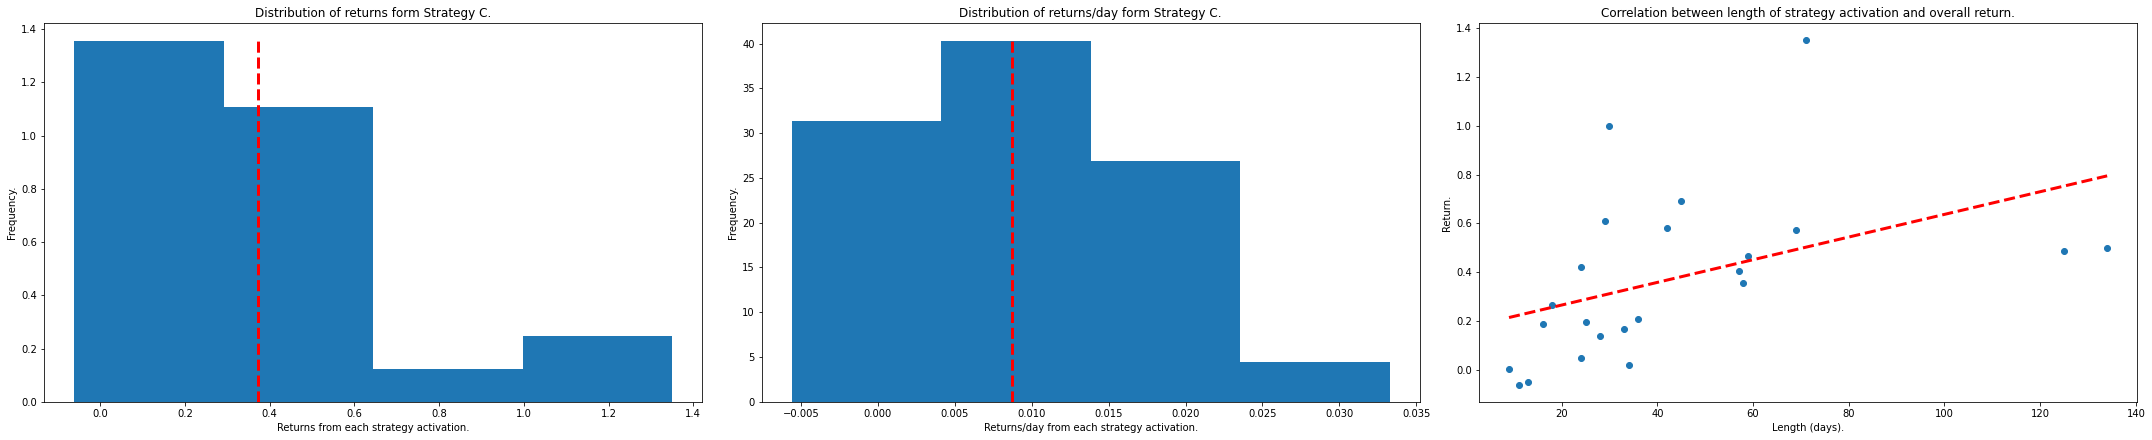

In [26]:
data = dataOriginal.copy()
# OSCPeriod1 = 12
# OSCPeriod2 = 26
# OSCPeriod3 = 9
# OSCLow = 0
# OSCHigh = 0

OSCPeriod1 = 15
OSCPeriod2 = 24
OSCPeriod3 = 11
OSCLow = -0.004444444444444445
OSCHigh = 0.004444444444444445

%time arrReturn, arrLength, arrPurchased, score, N, parameters = ff.backtestStrategyC(dataOriginal['close'].values, OSCPeriod1, OSCPeriod2, OSCPeriod3, OSCLow, OSCHigh, nLimits)
print("Mean Return: " + str(np.mean(arrReturn)))
print("Mean Daily Return for active periods: " + str(np.mean(arrReturn/arrLength)))
print("Mean Daily Return Overall: " + str((np.prod(1+arrReturn) - 1)/len(arrPurchased)))
print("Mean number of activations per day: " + str(len(arrReturn)/len(arrPurchased)))
print("Strategy Score: " + str(score))

fig, ax = plt.subplots(1, 3, figsize = [30, 10/1.61])
n1, bins1, patches1 = ax[0].hist(arrReturn, bins = int(np.sqrt(len(arrReturn))), density = True)
ax[0].set_title("Distribution of returns form Strategy C.")
ax[0].set_xlabel("Returns from each strategy activation.")
ax[0].set_ylabel("Frequency.")
ax[0].plot([np.mean(arrReturn), np.mean(arrReturn)],[0, np.max(n1)], 'r--', linewidth = 3.0)

n2, bins2, patches2 = ax[1].hist(arrReturn/arrLength, bins = int(np.sqrt(len(arrReturn))), density = True)
ax[1].set_title("Distribution of returns/day form Strategy C.")
ax[1].set_xlabel("Returns/day from each strategy activation.")
ax[1].set_ylabel("Frequency.")
ax[1].plot([np.mean(arrReturn/arrLength), np.mean(arrReturn/arrLength)],[0, np.max(n2)], 'r--', linewidth = 3.0)

ax[2].scatter(arrLength, arrReturn)
ax[2].set_title("Correlation between length of strategy activation and overall return.")
ax[2].set_xlabel("Length (days).")
ax[2].set_ylabel("Return.")
m, b = np.polyfit(arrLength, arrReturn, 1)
x = np.linspace(min(arrLength), max(arrLength))
y = m*x + b
ax[2].plot(x, y, 'r--', linewidth = 3.0)

fig.tight_layout()

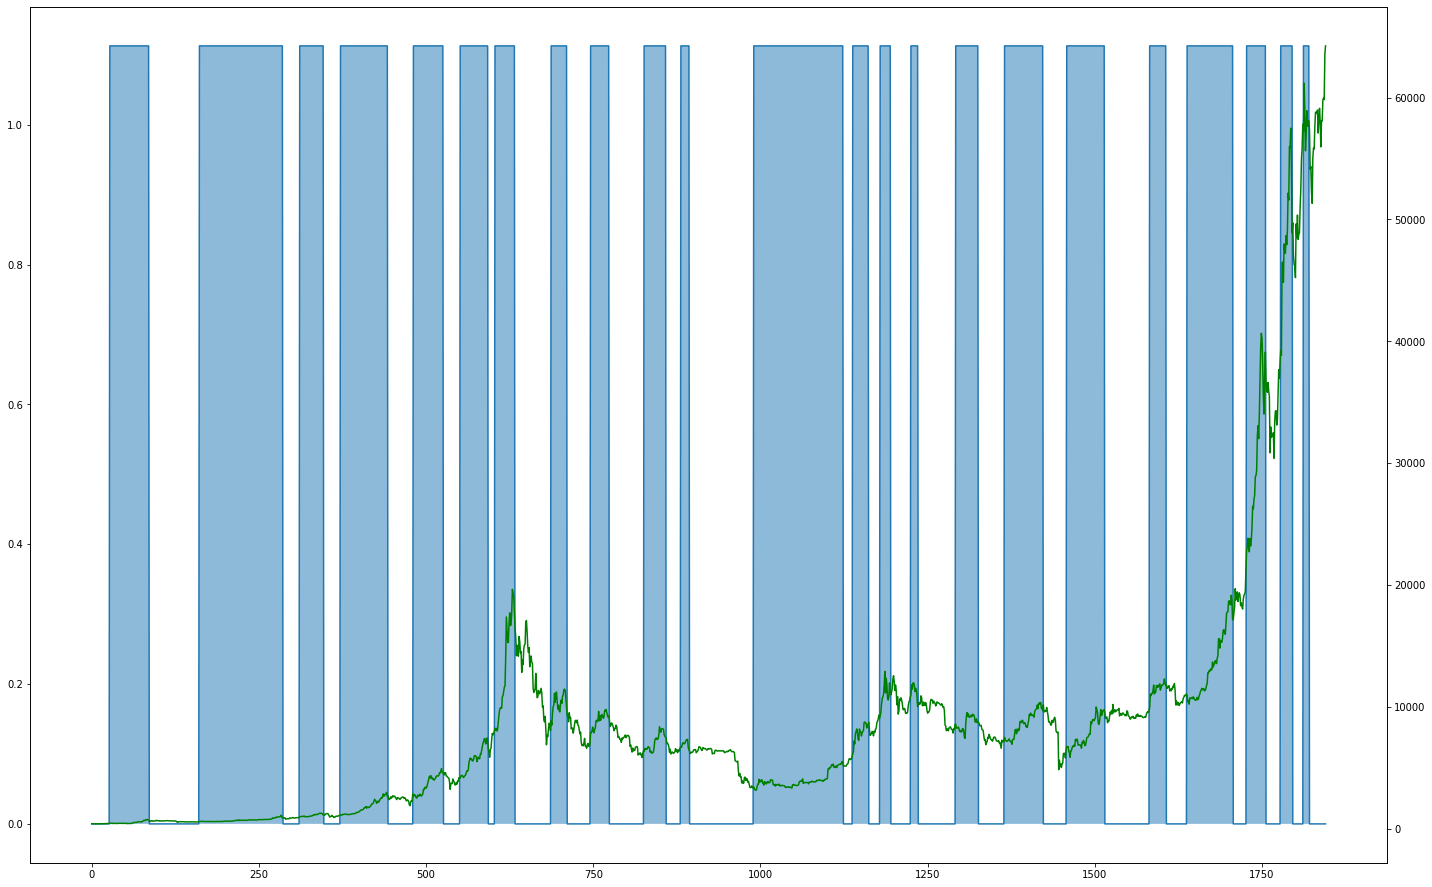

In [28]:
fig, ax = plt.subplots(figsize = [20, 20/1.61])
ax.plot(arrPurchased*score)
ax.fill_between(np.arange(len(arrPurchased)),arrPurchased*score, alpha = .5)
ax2 = ax.twinx()
ax2.plot(data['close'].values, color = 'green')
fig.tight_layout()

In [29]:
#Optimizing Strategy A Parameters
OSCperiod1Vals = np.arange(10,40)
OSCperiod2Vals = np.arange(20,50)
OSCperiod3Vals = np.arange(7,20)

OSCLowVals = np.linspace(-0.04,0.04, num = 10)
OSCHighVals = np.linspace(-0.04, 0.04, num = 10)
#Minimum of one activation every 90 days
minN = int(len(dataOriginal)/90)
#Maximum of one activation per 4 days
maxN = int(len(dataOriginal)/4)
argCombinations = []
for p1 in OSCperiod1Vals:
    for p2 in OSCperiod2Vals:
        for p3 in OSCperiod3Vals:
            for p4 in OSCLowVals:
                for p5 in OSCHighVals:
                    if p2 > p1 > p3 and p5 > p4:
                        argCombinations += [(dataOriginal['close'].values, p1, p2, p3, p4, p5, np.array([minN, maxN], dtype = np.float64))]

In [32]:
%%time
with ThreadPoolExecutor(8) as ex:   
    results = ex.map(lambda p: ff.backtestStrategyC(*p), argCombinations)
results = np.array([result for result in results])

<timed exec>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


CPU times: user 56.1 s, sys: 7.07 s, total: 1min 3s
Wall time: 31.1 s


In [33]:
results_df = pd.DataFrame(results, columns = ['returns', 'lengths', 'purchasedBool', 'score', 'N', 'parameters'])
results_df = results_df.sort_values(by = 'score')
best = results_df.tail(10).sort_values(by = 'N').iloc[-1]
if best['score'] < 0:
    best['score'] = 0
best.to_dict()

{'returns': array([ 0.46516272,  0.4854883 ,  0.20604382,  1.35034704,  0.69269412,
         0.58230354,  0.9981674 ,  0.04875973,  0.13826554,  0.1676636 ,
        -0.05083621,  0.49692441,  0.41986384,  0.18614525, -0.06171709,
         0.01989403,  0.35604401,  0.40533707,  0.19346746,  0.57074652,
         0.61017686,  0.26670764,  0.00240119]),
 'lengths': array([ 59., 125.,  36.,  71.,  45.,  42.,  30.,  24.,  28.,  33.,  13.,
        134.,  24.,  16.,  11.,  34.,  58.,  57.,  25.,  69.,  29.,  18.,
          9.]),
 'purchasedBool': array([False, False, False, ..., False, False, False]),
 'score': 1.1127860230293813,
 'N': 23,
 'parameters': array([ 1.50000000e+01,  2.40000000e+01,  1.10000000e+01, -4.44444444e-03,
         4.44444444e-03])}

In [34]:
start = datetime.datetime(2016,3,27)
end = datetime.datetime.now()
granularity = 24*60*60
allCloseData = np.array([cf.getData(Client, asset, start, end, granularity = granularity)['close'].values for asset in assets])
clear_output()


In [35]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrAParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreA = np.array([ff.backtestStrategyA(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])


In [36]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrBParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreB = np.array([ff.backtestStrategyB(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])


In [37]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrCParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreC = np.array([ff.backtestStrategyC(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], parameters[i][3], parameters[i][4], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])

In [38]:
totalScores = currentScoreA + currentScoreB + currentScoreC
#USD score is 1/2 the mean score
totalScores = np.append(totalScores, [0.5*np.mean(totalScores)])
portfolioWeights = totalScores/sum(totalScores)
portfolio86400 = {(assets + ['USD-USD'])[i]:portfolioWeights[i] for i in range(len(assets + ['USD-USD']))}

In [ ]:
start = datetime.datetime(2016,3,27)
end = datetime.datetime.now()
granularity = 6*60*60
allCloseData = np.array([cf.getData(Client, asset, start, end, granularity = granularity, verbose = False)['close'].values for asset in assets])
clear_output()

In [ ]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrAParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreA = np.array([ff.backtestStrategyA(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])

In [ ]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrBParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreB = np.array([ff.backtestStrategyB(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])


In [ ]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrCParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreC = np.array([ff.backtestStrategyC(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], parameters[i][3], parameters[i][4], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])


In [ ]:
totalScores = currentScoreA + currentScoreB + currentScoreC
#USD score is 1/2 the mean score
totalScores = np.append(totalScores, [0.5*np.mean(totalScores)])
portfolioWeights = totalScores/sum(totalScores)
portfolio21600 = {(assets + ['USD-USD'])[i]:portfolioWeights[i] for i in range(len(assets + ['USD-USD']))}


In [ ]:
start = datetime.datetime(2016,3,27)
end = datetime.datetime.now()
granularity = 60*60
allCloseData = np.array([cf.getData(Client, asset, start, end, granularity = granularity, verbose = False)['close'].values for asset in assets])
clear_output()

In [ ]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrAParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreA = np.array([ff.backtestStrategyA(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])

In [ ]:

parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrBParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreB = np.array([ff.backtestStrategyB(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])

In [ ]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrCParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreC = np.array([ff.backtestStrategyC(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], parameters[i][3], parameters[i][4], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])



In [ ]:
totalScores = currentScoreA + currentScoreB + currentScoreC
#USD score is 1/2 the mean score
totalScores = np.append(totalScores, [0.5*np.mean(totalScores)])
portfolioWeights = totalScores/sum(totalScores)
portfolio3600 = {(assets + ['USD-USD'])[i]:portfolioWeights[i] for i in range(len(assets + ['USD-USD']))}


In [ ]:
finalPortfolio = {key:(portfolio3600[key] + portfolio21600[key] + portfolio86400[key])/3 for key in portfolio3600.keys()}


In [40]:
for granularity in [24*60*60, 6*60*60, 60*60]:
    for asset in assets[1:]:
        clear_output()
        print(asset + " - " + str(granularity))
        cf.updateData(Client, asset, granularity, verbose = False)

ZRX-USD - 3600
Retrieving data for ZRX-USD

Retrieving data for ZRX-USD
Failure in retreiving data for ZRX-USD. Waiting 1 second and trying again. 1/10
{'message': 'Public rate limit exceeded'}


In [67]:
hist = pd.read_csv("/home/andrerg01/AutoTraders/fredinhouTradingBot/Coinbase_Trader_4.0/logs/hist.csv", parse_dates=['Date'], converters = {'Portfolio': eval}).set_index('Date')

In [4]:
hist

,Funds,Portfolio,Rebalance,Buys,Sells
Date,,,,,
2021-03-25 15:19:06.451740,99.585425,"{'AAVE-USD': 0.0, 'ADA-USD': 0.0, 'ALGO-USD': ...",0.0,{},{}
2021-03-25 15:34:12.675508,99.908841,"{'AAVE-USD': 0.0, 'ADA-USD': 0.0, 'ALGO-USD': ...",0.0,{},{}
2021-03-25 15:47:29.364564,99.908841,"{'AAVE-USD': 0.0, 'ADA-USD': 0.0, 'ALGO-USD': ...",0.0,{},{}
2021-03-25 16:41:24.426234,99.759576,"{'AAVE-USD': 0.0, 'ADA-USD': 0.0, 'ALGO-USD': ...",0.0,{},{}
2021-03-25 17:48:13.093859,100.789031,"{'AAVE-USD': 0.0, 'ADA-USD': 0.0, 'ALGO-USD': ...",0.0,{},{}
...,...,...,...,...,...
2021-04-16 19:02:30.621819,150.677989,"{'AAVE-USD': 0.14677635692179242, 'ADA-USD': 0...",0.0,"{'FIL-USD': 0.04715085412654737, 'NMR-USD': 0....","{'AAVE-USD': 0.009659760192524115, 'ADA-USD': ..."
2021-04-16 20:01:57.597479,149.579952,"{'AAVE-USD': 0.1467428938557484, 'ADA-USD': 0....",0.0,"{'ALGO-USD': 0.7175858840846903, 'REN-USD': 0....","{'AAVE-USD': 0.009814294170962112, 'ADA-USD': ..."
2021-04-16 21:01:27.274083,151.107099,"{'AAVE-USD': 0.11714356098505033, 'ADA-USD': 0...",0.0,"{'ALGO-USD': 0.6478701813551094, 'REN-USD': 0....","{'AAVE-USD': 0.010247281441605825, 'ADA-USD': ..."


In [107]:
def makePricePlot(hist, ax):
    ax.plot(hist['Funds'], label = 'Total Funds', color = 'green')
    ax.set_xlabel("Date")
    ax.set_ylabel("Total Funds (USD)")
    ax.set_title("Funds History")
    ax.grid()
    
def makeTimePortfolioPlot(hist, ax):
    everInvestedAssets = []
    for port in hist['Portfolio']:
        for key in port.keys():
            if port[key] > 0 and key not in everInvestedAssets:
                everInvestedAssets += [key]
    assetInvestOverTime = {asset:[] for asset in everInvestedAssets}
    for port in hist['Portfolio']:
        for asset in everInvestedAssets:
            if asset in port.keys():
                assetInvestOverTime[asset] += [port[asset]]
            else:
                assetInvestOverTime[asset] += [0]
    for asset in everInvestedAssets:
        ax.plot(hist.index, assetInvestOverTime[asset], label = asset)
    ax.legend(title='Asset', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title('Asset share in portfolio over time.')
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio share")
    ax.grid()
    
def makeTimePortfolioPlot(hist, ax):
    boxProps = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    everInvestedAssets = []
    for port in hist['Portfolio']:
        for key in port.keys():
            if port[key] > 0 and key not in everInvestedAssets:
                everInvestedAssets += [key]
    assetInvestOverTime = {asset:[] for asset in everInvestedAssets}
    for port in hist['Portfolio']:
        for asset in everInvestedAssets:
            if asset in port.keys():
                assetInvestOverTime[asset] += [port[asset]]
            else:
                assetInvestOverTime[asset] += [0]
    for i in range(len(everInvestedAssets)):
        if i == 0:
            y1 = assetInvestOverTime[everInvestedAssets[i]]
            ax.fill_between(hist.index, y1)
            if assetInvestOverTime[everInvestedAssets[i]][-1] > 0.01:
                x = hist.index[-1]
                y = assetInvestOverTime[everInvestedAssets[i]][-1]/2
                ax.text(x, y, everInvestedAssets[i], bbox = boxProps)
        else:
            y1 = assetInvestOverTime[everInvestedAssets[i]] + sum([np.array(assetInvestOverTime[everInvestedAssets[j]]) for j in range(i)])
            y2 = sum([np.array(assetInvestOverTime[everInvestedAssets[j]]) for j in range(i)])
            ax.fill_between(hist.index, y1, y2, where = y1 > y2, interpolate = True)
            if assetInvestOverTime[everInvestedAssets[i]][-1] > 0.01:
                x = hist.index[-1]
                y = assetInvestOverTime[everInvestedAssets[i]][-1]/2 + sum([np.array(assetInvestOverTime[everInvestedAssets[j]]) for j in range(i)])[-1]
                ax.text(x, y, everInvestedAssets[i], bbox = boxProps)
    ax.set_title('Asset share in portfolio over time.')
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio share")
    ax.grid() 

def makeCurrentPortfolioPlot(hist, ax):
    everInvestedAssets = []
    for port in hist['Portfolio']:
        for key in port.keys():
            if port[key] > 0 and key not in everInvestedAssets:
                everInvestedAssets += [key]
    heights = [hist.iloc[-1]['Portfolio'][asset] for asset in hist.iloc[-1]['Portfolio'].keys()]
    ax.bar([asset[:3] for asset in hist.iloc[-1]['Portfolio'].keys()], heights)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_xlabel("Asset")
    ax.set_ylabel("Share in current portfolio")
    ax.set_title("Layout of current portfolio")
    ax.grid()

def makeMarketPerformancePlot(allCloseRelevant, hist, ax):
    equalWeightFunds = [1 for _ in range(len(allCloseRelevant[0]))]
    
    equalWeightReturns = [0 for _ in range(len(allCloseRelevant[0]))]
    for i in range(len(allCloseRelevant)):
        for j in range(1, len(allCloseRelevant[i])):
            equalWeightReturns[j] = (allCloseRelevant[i][j] - allCloseRelevant[i][j-1])/allCloseRelevant[i][j-1]/len(allCloseRelevant)
            equalWeightFunds[j] = equalWeightFunds[j-1]*(1+equalWeightReturns[j])
    ax.plot(equalWeightFunds, '--', color = 'blue', label = 'Equally Weighted Backtest')    
    ax.set_title("Market Performance")
    ax.set_ylabel("Equally Weighted Portfolio Funds")
    ax.set_xlabel("Periods")
    ax.legend(loc='upper left')
    ax.grid()
#ax.set_yscale('log')

    


In [17]:
end = datetime.datetime.now()
allData = [cf.getData(Client, asset, start, end, 60*60, verbose = False) for asset in assets]
clear_output()

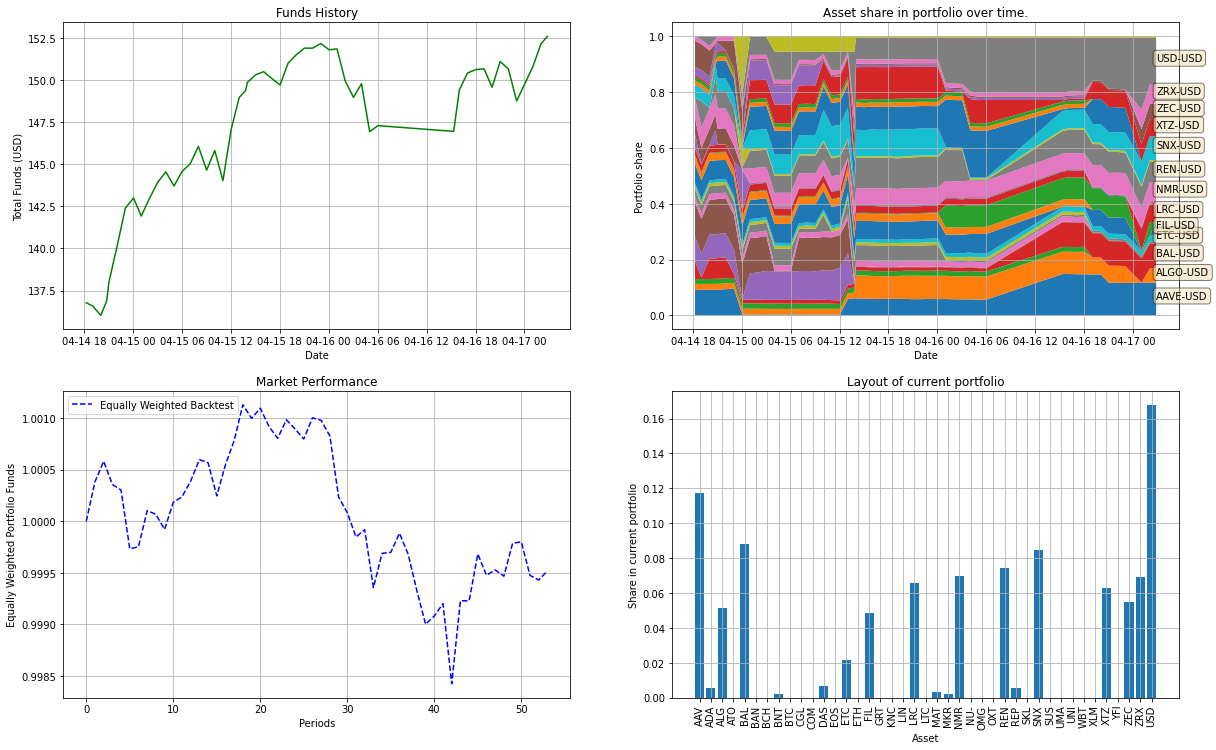

In [108]:
fig, ax = plt.subplots(2, 2, figsize = [20,20/1.61])
#histTemp = hist[datetime.datetime(2021, 4, 13):]
histTemp = hist[datetime.datetime.now() - datetime.timedelta(days = 7):].copy()
makePricePlot(histTemp, ax[0, 0])
makeTimePortfolioPlot(histTemp, ax[0, 1])
makeMarketPerformancePlot([d[histTemp.index[0]:]['close'].values for d in allData], histTemp, ax[1, 0])
makeCurrentPortfolioPlot(histTemp, ax[1, 1])
#fig.tight_layout()

## Backtest Multi-Asset Strategy A

### 86400

In [388]:
backtestDateStart = datetime.datetime(2020,1,1)
#backtestDateEnd = datetime.datetime(2021,1,1)
backtestDateEnd = datetime.datetime.now()
granularity = 60*60*24
nOfDays = int((backtestDateEnd - backtestDateStart).total_seconds()/datetime.timedelta(seconds = granularity).total_seconds()+1)
backtestDateCurrent = backtestDateStart
allData86400 = [cf.getData(Client, asset, start, backtestDateEnd, granularity, verbose = False) for asset in assets]
clear_output()

In [389]:
goodAllData86400 = []
goodAssets = []
goodAllCloseData86400 = []
for i in range(len(assets)):
    if len(allData86400[i][backtestDateStart:backtestDateEnd]) == nOfDays and allData86400[i][backtestDateStart:].index[0] == backtestDateStart:
        goodAllData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]]
        goodAllCloseData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]['close'].values]
        goodAssets += [assets[i]]
fullTimeScore = []

scoreHist = []
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'A' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
    nLims = np.array([2,max([len(data) for data in goodAllCloseData86400])])
    scoreHist += [ff.backtestStrategyA(goodAllCloseData86400[i], parameters[0], parameters[1], parameters[2], nLims)[2]*score]
currentPortfolioSize = {(goodAssets + ['USD-USD'])[i]:0 for i in range(len(goodAssets + ['USD-USD']))}
currentPortfolioSize['USD-USD'] = 100
totalFunds = 100
fundsHist = []
for i in range(len(scoreHist[0])):
    currentPrices = {goodAssets[j]:goodAllCloseData86400[j][i] for j in range(len(goodAssets))}
    currentPrices['USD-USD'] = 1
    totalFunds = sum([currentPortfolioSize[key]*currentPrices[key] for key in currentPrices.keys()])
    
    goalPortfolio = {goodAssets[j]:scoreHist[j][i] for j in range(len(goodAssets))}
    goalPortfolio['USD-USD'] = 0.000001
    goalPortfolio = ff.nicefyPortfolio(goalPortfolio, 0.00)
    
    goalPortfolioSize = {key:goalPortfolio[key]*totalFunds/currentPrices[key] for key in currentPrices.keys()}
            
    currentPortfolioSize = goalPortfolioSize

    fundsHist += [totalFunds]


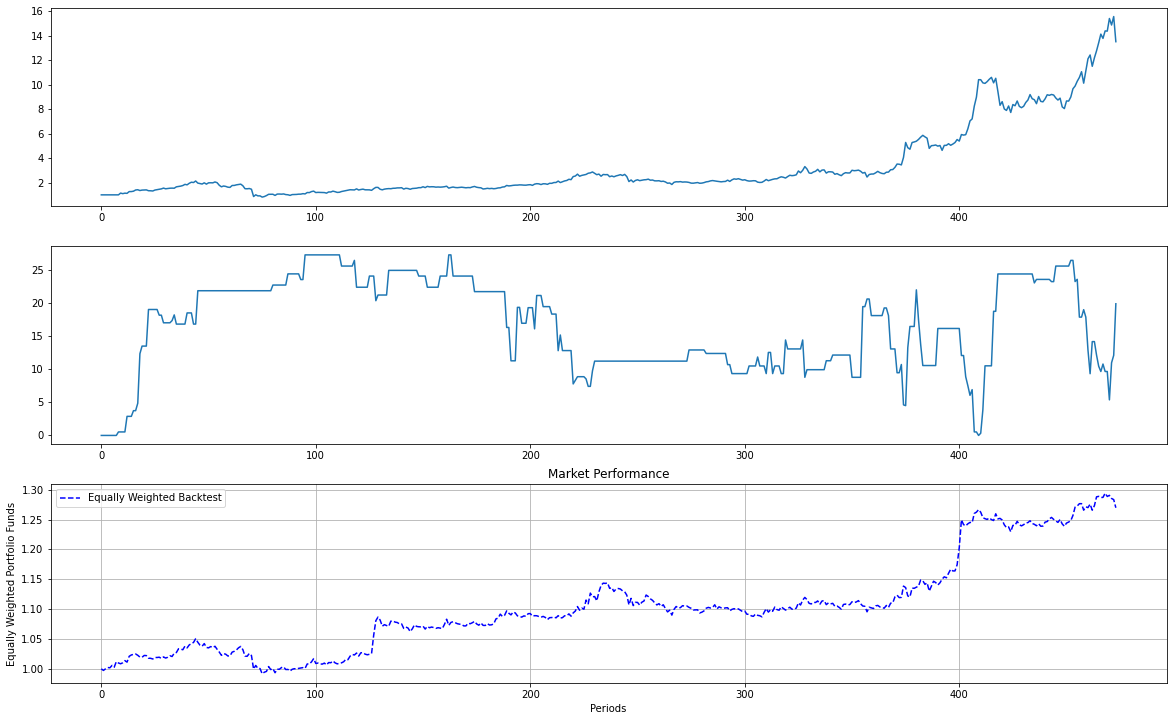

In [390]:
fig, ax = plt.subplots(3, figsize = [20,20/1.61])
ax[0].plot(np.array(fundsHist)/100)
ax[1].plot(sum([np.array(scoreHist[i]) for i in range(len(scoreHist))]))
#ax[1].plot(scoreHist[1])
ff.makeMarketPerformancePlot(goodAllCloseData86400, ax[2])

## Backtest Multi-Asset Strategy B

In [391]:
goodAllData86400 = []
goodAssets = []
goodAllCloseData86400 = []
for i in range(len(assets)):
    if len(allData86400[i][backtestDateStart:backtestDateEnd]) == nOfDays and allData86400[i][backtestDateStart:].index[0] == backtestDateStart:
        goodAllData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]]
        goodAllCloseData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]['close'].values]
        goodAssets += [assets[i]]
fullTimeScore = []

scoreHist = []
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'B' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
    nLims = np.array([2,max([len(data) for data in goodAllCloseData86400])])
    scoreHist += [ff.backtestStrategyB(goodAllCloseData86400[i], parameters[0], parameters[1], parameters[2], nLims)[2]*score]
currentPortfolioSize = {(goodAssets + ['USD-USD'])[i]:0 for i in range(len(goodAssets + ['USD-USD']))}
currentPortfolioSize['USD-USD'] = 100
totalFunds = 100
fundsHist = []
for i in range(len(scoreHist[0])):
    currentPrices = {goodAssets[j]:goodAllCloseData86400[j][i] for j in range(len(goodAssets))}
    currentPrices['USD-USD'] = 1
    totalFunds = sum([currentPortfolioSize[key]*currentPrices[key] for key in currentPrices.keys()])
    
    goalPortfolio = {goodAssets[j]:scoreHist[j][i] for j in range(len(goodAssets))}
    goalPortfolio['USD-USD'] = 0.000001
    goalPortfolio = ff.nicefyPortfolio(goalPortfolio, 0.00)
    
    goalPortfolioSize = {key:goalPortfolio[key]*totalFunds/currentPrices[key] for key in currentPrices.keys()}
            
    currentPortfolioSize = goalPortfolioSize

    fundsHist += [totalFunds]


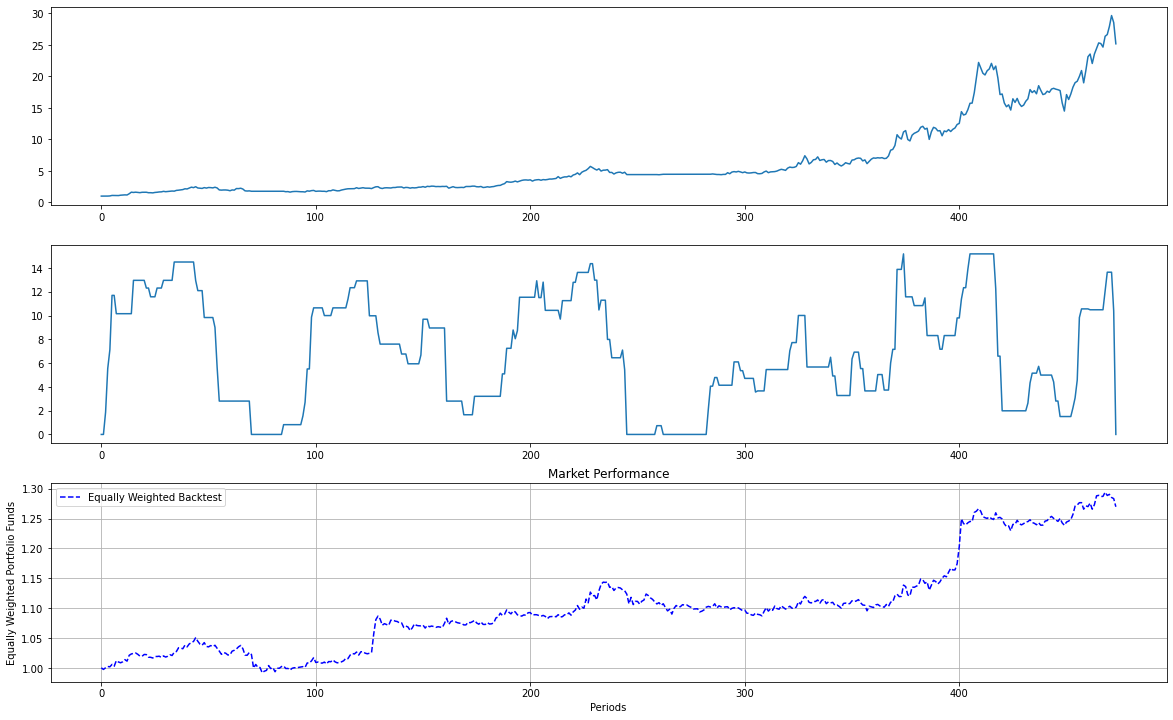

In [392]:
fig, ax = plt.subplots(3, figsize = [20,20/1.61])
ax[0].plot(np.array(fundsHist)/100)
ax[1].plot(sum([np.array(scoreHist[i]) for i in range(len(scoreHist))]))
#ax[1].plot(scoreHist[1])
ff.makeMarketPerformancePlot(goodAllCloseData86400, ax[2])

## Backtest Multi-Asset Strategy C

In [393]:
goodAllData86400 = []
goodAssets = []
goodAllCloseData86400 = []
for i in range(len(assets)):
    if len(allData86400[i][backtestDateStart:backtestDateEnd]) == nOfDays and allData86400[i][backtestDateStart:].index[0] == backtestDateStart:
        goodAllData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]]
        goodAllCloseData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]['close'].values]
        goodAssets += [assets[i]]
fullTimeScore = []

scoreHist = []
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'C' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
    nLims = np.array([2,max([len(data) for data in goodAllCloseData86400])])
    scoreHist += [ff.backtestStrategyC(goodAllCloseData86400[i], parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], nLims)[2]*score]
currentPortfolioSize = {(goodAssets + ['USD-USD'])[i]:0 for i in range(len(goodAssets + ['USD-USD']))}
currentPortfolioSize['USD-USD'] = 100
totalFunds = 100
fundsHist = []
for i in range(len(scoreHist[0])):
    currentPrices = {goodAssets[j]:goodAllCloseData86400[j][i] for j in range(len(goodAssets))}
    currentPrices['USD-USD'] = 1
    totalFunds = sum([currentPortfolioSize[key]*currentPrices[key] for key in currentPrices.keys()])
    
    goalPortfolio = {goodAssets[j]:scoreHist[j][i] for j in range(len(goodAssets))}
    goalPortfolio['USD-USD'] = 0.000001
    goalPortfolio = ff.nicefyPortfolio(goalPortfolio, 0.00)
    
    goalPortfolioSize = {key:goalPortfolio[key]*totalFunds/currentPrices[key] for key in currentPrices.keys()}
            
    currentPortfolioSize = goalPortfolioSize

    fundsHist += [totalFunds]


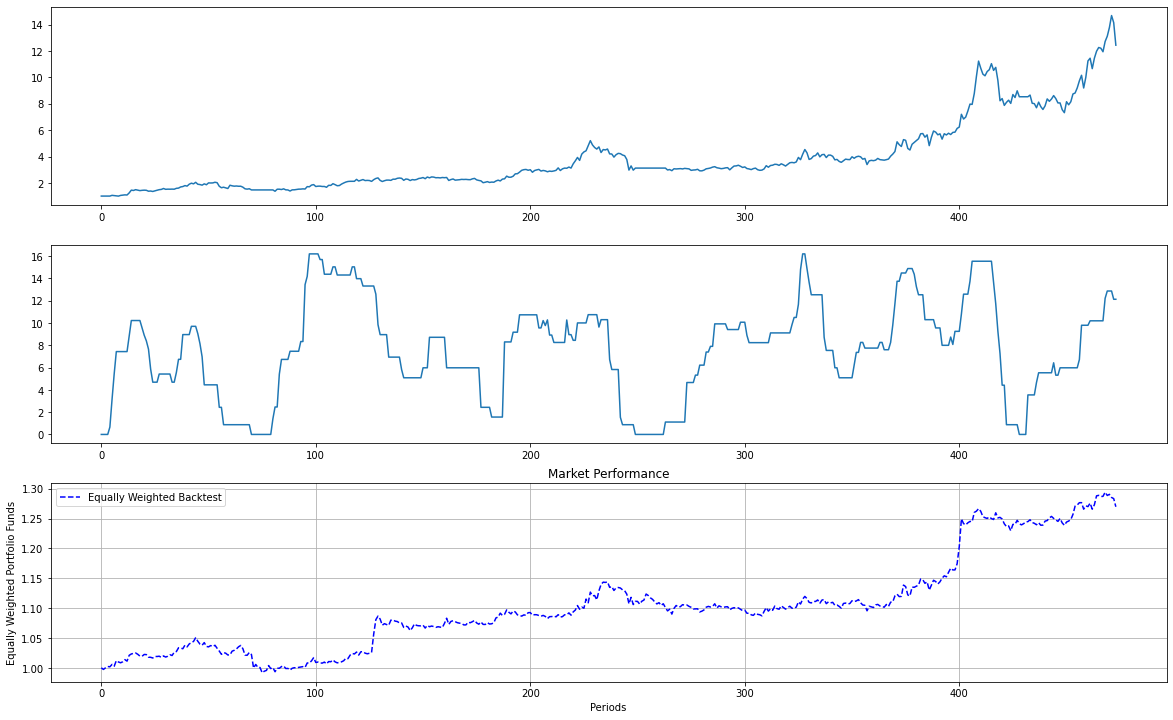

In [394]:
fig, ax = plt.subplots(3, figsize = [20,20/1.61])
ax[0].plot(np.array(fundsHist)/100)
ax[1].plot(sum([np.array(scoreHist[i]) for i in range(len(scoreHist))]))
#ax[1].plot(scoreHist[1])
ff.makeMarketPerformancePlot(goodAllCloseData86400, ax[2])

In [395]:
goodAssets

['ALGO-USD',
 'BCH-USD',
 'BTC-USD',
 'DASH-USD',
 'EOS-USD',
 'ETC-USD',
 'ETH-USD',
 'LINK-USD',
 'LTC-USD',
 'OXT-USD',
 'REP-USD',
 'XLM-USD',
 'XTZ-USD',
 'ZRX-USD']